In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install SimpleITK

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import cv2 as cv

import inspect
path = "/content/drive/Shareddrives/IA DL_project/ML IA/IMAGE_PROCESSING_PIPELINE"

if path not in sys.path:
  sys.path.append(path)

import luna_module
from luna_module import *

# List all function names in the luna_module
function_names = [name for name, obj in inspect.getmembers(luna_module) if inspect.isfunction(obj)]
print(function_names)

['annotations_by_uid', 'binarize_lung', 'binarize_lung_3d', 'binary_closing', 'binary_dilation', 'binary_erosion', 'binary_fill_holes', 'binary_opening', 'center_of_mass', 'clear_border', 'convert_annotation_df', 'convert_annotation_df_with_uid', 'create_3d_mask', 'create_annotations_mask', 'create_annotations_mask_by_uid', 'create_patch', 'debugger', 'draw_ellipsoid', 'find_by_uid', 'find_neighborhood_indices', 'find_neighborhood_indices_more_precise', 'get_slice_candidates', 'get_slice_candidates_old', 'get_slices', 'get_uids', 'img_by_uid', 'masked_annotations_by_uid', 'masked_annotations_with_info_by_uid', 'meta_by_uid', 'norm2float', 'norm2uint16', 'norm2uint8', 'normalize_intensity', 'plot_slices', 'process_slice_candidates', 'process_slice_candidates_old', 'process_slices', 'remove_non_central_objects', 'sensitivity_score', 'sensitivity_score_more_precise', 'show_3_images', 'subset_by_uid', 'unwanted_object_filter']


In [ ]:
LUNA_PATH = os.path.join(os.getcwd(), "drive", "Shareddrives", "IA DL_project", "ML IA", "LUNA16")

SUBSET = "subset1"

SUBSETS_PATH = os.path.join(LUNA_PATH, "candidates", "solidity_on_z") # path for subsets folder
CANDIDATES_CSV_PATH =  os.path.join(SUBSETS_PATH, SUBSET, f"{SUBSET}_candidates.csv") # path for subsets folder with y filtered candidates
# SAVE_FOLDER_PATH = os.path.join(LUNA_PATH, "feature_extractions", "pretrained_gabors")


CANDIDATES_DF = pd.read_csv(CANDIDATES_CSV_PATH, index_col="Unnamed: 0")

FILENAMES = os.listdir(os.path.join(SUBSETS_PATH, SUBSET, "y"))
UIDS = set(map(lambda filename: os.path.splitext(filename)[0], FILENAMES))

In [ ]:
CANDIDATES_DF[CANDIDATES_DF['Class']==1]

,seriesuid,x,y,z,Class
419,1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...,114,259,100,1.0
420,1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...,122,262,101,1.0
2809,1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...,143,286,187,1.0
2820,1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...,144,294,187,1.0
3019,1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...,153,290,195,1.0
...,...,...,...,...,...
63481,1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663...,156,421,149,1.0
63482,1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663...,152,435,150,1.0
63500,1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663...,155,426,152,1.0
63504,1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663...,150,429,155,1.0


# FEATURE FUNCTIONS

## HAAR

In [ ]:
def create_center_surround_kernel(size, inner_size):
    kernel = np.zeros((size, size), dtype=np.float32)

    # Define the start and end points of the inner region
    start = (size - inner_size) // 2
    end = start + inner_size

    # Set the central region to +1
    kernel[start:end, start:end] = 1

    # Set the surround region to -1
    kernel[:start, :] = -1
    kernel[end:, :] = -1
    kernel[:, :start] = -1
    kernel[:, end:] = -1

    return kernel

def create_four_rectangle_kernel(size):
    kernel = np.zeros((size, size), dtype=np.float32)

    half_size = size // 2

    # Top-left and bottom-right rectangles (+1)
    kernel[:half_size, :half_size] = 1
    kernel[half_size:, half_size:] = 1

    # Top-right and bottom-left rectangles (-1)
    kernel[:half_size, half_size:] = -1
    kernel[half_size:, :half_size] = -1

    return kernel

def extract_haar_features(p_haar, kernel):
    # Ensure the patch and kernel are float32
    p_haar = p_haar.astype(np.float32)
    kernel = kernel.astype(np.float32)

    # Apply the kernel to the patch using convolution
    filtered_patch = cv.filter2D(p_haar, -1, kernel)
    return filtered_patch

def multi_scale_haar_features(p_haar, kernel, scales):
    haar_features_list = []

    for scale in scales:
        # Resize the patch
        p_haar = p_haar.astype('float32')

        row_th = int(p_haar.shape[0]*scale)
        col_th = int(p_haar.shape[1]*scale)

        scaled_patch = cv.resize(p_haar, (row_th, col_th))
        # scaled_patch = cv.resize(p_haar, (row_th, col_th), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)

        # Ensure the scaled patch is valid
        if scaled_patch.size == 0:
            raise ValueError(f"Scaled patch is empty at scale {scale}")

        # Extract Haar features from the scaled patch
        haar_features = extract_haar_features(scaled_patch, kernel)
        haar_features_list.append(haar_features)

        # Find the location of the maximum response
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(haar_features)

    return haar_features_list


# Function to pad a feature map to a specified size
def pad_feature_map(feature_map, target_size):
    padded_feature_map = np.zeros((target_size, target_size), dtype=np.float32)
    current_size = feature_map.shape[0]

    # Calculate padding offsets
    offset = (target_size - current_size) // 2

    # Place the feature map in the center of the padded array
    padded_feature_map[offset:offset + current_size, offset:offset + current_size] = feature_map

    return padded_feature_map

def combine_and_average_feature_maps(feature_maps, target_size):
    padded_feature_maps = [pad_feature_map(fm, target_size) for fm in feature_maps]
    combined_feature_map = np.mean(padded_feature_maps, axis=0)

    return combined_feature_map

def combine_and_weighted_average_feature_maps(feature_maps, target_size, weights):
    weighted_sum = np.zeros((target_size, target_size), dtype=np.float32)
    total_weight = 0

    for feature_map, weight in zip(feature_maps, weights):
        padded_feature_map = pad_feature_map(feature_map, target_size)
        weighted_sum += padded_feature_map * weight
        total_weight += weight

    combined_feature_map = weighted_sum / total_weight
    return combined_feature_map

def custom_pooling(feature_map, kernel_size, pooling_type='avg'):
    h, w = feature_map.shape
    pooled_map = np.zeros((h // kernel_size, w // kernel_size), dtype=np.float32)

    for i in range(0, h, kernel_size):
        for j in range(0, w, kernel_size):
            patch = feature_map[i:i + kernel_size, j:j + kernel_size]
            if pooling_type == 'avg':
                pooled_map[i // kernel_size, j // kernel_size] = np.mean(patch)
            elif pooling_type == 'max':
                pooled_map[i // kernel_size, j // kernel_size] = np.max(patch)
            else:
                raise ValueError("Pooling type must be 'avg' or 'max'")

    return pooled_map

def haar_pooled(patch, kerneltype, target_size = 48):
    """
    Perform multi-scale Haar feature extraction and pooling on the input patch.

    Args:
        p_haar (np.ndarray): The input patch.
        kerneltype (str): Type of Haar kernel ('cs' for center-surround, 'fr' for four-rectangle).
        target_size (int): Desired size of patch rectangle

    Returns:
        tuple: Pooled feature maps (average pooling, max pooling).
    """
    # Initialize Haar parameters
    kernel_size_cs = 8
    inner_size_cs = 4
    size_fr = 8

    # Define scales based on patch size
    scales = [1, 0.875, 0.75, 0.625, 0.5, 0.375, 0.25, 0.125] if patch.shape[0] == 64 else [1, 0.875, 0.75, 0.625, 0.5, 0.375, 0.25]

    # Calculate weights for the scales
    weights = [1 / scale for scale in scales]
    weights = [w / sum(weights) for w in weights]

    # Pooling parameters
    kernel_poolsize = 8

    # Select the appropriate kernel
    if kerneltype == 'cs':
        kernel = create_center_surround_kernel(kernel_size_cs, inner_size_cs)
    elif kerneltype == 'fr':
        kernel = create_four_rectangle_kernel(size_fr)
    else:
        raise ValueError("Kernel type must be 'cs' (center-surround) or 'fr' (four-rectangle)")

    # Extract Haar features at multiple scales
    haar_features_list = multi_scale_haar_features(patch, kernel, scales)

    # Combine and weight the feature maps
    combined_feature_map = combine_and_weighted_average_feature_maps(haar_features_list, target_size, weights)
    # combined_feature_map = combine_and_average_feature_maps(haar_features_list, target_size)

    # Perform custom pooling
    pooled_feature_map_avg = custom_pooling(combined_feature_map, kernel_poolsize, pooling_type='avg')
    pooled_feature_map_max = custom_pooling(combined_feature_map, kernel_poolsize, pooling_type='max')

    return pooled_feature_map_avg, pooled_feature_map_max


# Example usage
# p_haar = #your patch
# pooled_avg, pooled_max = haar_pooled(p_haar, 'cs')


## GABOR

In [ ]:
def create_gabor_kernels(ksize=32, sigma=4.0, lambd=10.0, gamma=0.5, psi=0):
    """
    Create a set of Gabor kernels with different orientations and frequencies.

    Args:
        ksize (int): Size of the Gabor kernel.
        sigma (float): Standard deviation of the Gaussian function.
        lambd (float): Wavelength of the sinusoidal factor.
        gamma (float): Spatial aspect ratio.
        psi (float): Phase offset.

    Returns:
        list: A list of Gabor kernels.
    """
    kernels = []
    for theta in np.arange(0, np.pi, np.pi / 8):  # 8 orientations
        kernel = cv.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv.CV_32F)
        kernels.append(kernel)
    return kernels

def apply_gabor_kernels(patch, kernels):
    """
    Apply Gabor kernels to a patch to extract features.

    Args:
        patch (np.ndarray): The input image patch (64x64).
        kernels (list): A list of Gabor kernels.

    Returns:
        np.ndarray: The combined Gabor feature vector.
    """
    features = []
    for kernel in kernels:
        filtered_patch = cv.filter2D(patch, cv.CV_32F, kernel)
        features.append(filtered_patch)

    # Combine features (e.g., by flattening and concatenating)
    combined_features = np.hstack([f.flatten() for f in features])
    return combined_features

def apply_gabor_kernels_and_compute_mean(patch, kernels):
    """
    Apply Gabor kernels to a patch and compute the mean feature map.

    Args:
        patch (np.ndarray): The input image patch (64x64).
        kernels (list): A list of Gabor kernels.

    Returns:
        np.ndarray: The mean Gabor feature map.
    """
    feature_maps = []
    for kernel in kernels:
        filtered_patch = cv.filter2D(patch, cv.CV_32F, kernel)
        feature_maps.append(filtered_patch)

    # Compute the mean feature map
    mean_feature_map = np.mean(feature_maps, axis=0)
    return mean_feature_map

def custom_pooling(feature_map, kernel_size, pooling_type='avg'):
    h, w = feature_map.shape
    pooled_map = np.zeros((h // kernel_size, w // kernel_size), dtype=np.float32)

    for i in range(0, h, kernel_size):
        for j in range(0, w, kernel_size):
            patch = feature_map[i:i + kernel_size, j:j + kernel_size]
            if pooling_type == 'avg':
                pooled_map[i // kernel_size, j // kernel_size] = np.mean(patch)
            elif pooling_type == 'max':
                pooled_map[i // kernel_size, j // kernel_size] = np.max(patch)
            else:
                raise ValueError("Pooling type must be 'avg' or 'max'")

    return pooled_map


def gabor_pooled(patch, kernel_poolsize=8):
    """
    Apply Gabor filters to the patch, compute mean feature map, and perform pooling.

    Args:
        patch (np.ndarray): The input image patch (64x64).
        kernel_poolsize (int): Size of the pooling kernel.

    Returns:
        tuple: Pooled feature maps (average pooling, max pooling).
    """
    # Create Gabor kernels
    kernels = create_gabor_kernels()

    # Apply Gabor kernels and compute the mean feature map
    mean_feature_map = apply_gabor_kernels_and_compute_mean(patch, kernels)

    # Perform custom pooling
    pooled_feature_map_avg = custom_pooling(mean_feature_map, kernel_poolsize, pooling_type='avg')
    pooled_feature_map_max = custom_pooling(mean_feature_map, kernel_poolsize, pooling_type='max')

    return pooled_feature_map_avg, pooled_feature_map_max

## HoG

In [ ]:
from skimage.feature import hog
from skimage import exposure

def extract_hog_features(patch):
    """
    Extract Histogram of Oriented Gradients (HOG) features from a given patch.

    Args:
        patch (np.ndarray): The input image patch (64x64).

    Returns:
        tuple: HOG features and HOG image.
    """
    # Ensure the patch is of type float32
    patch = patch.astype(np.float32)

    # Compute HOG features
    hog_features = hog(patch,
                        orientations=9,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        visualize=False)

    return hog_features

## ALL FEATURES

In [ ]:
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import regionprops, label
from skimage import io, color

def mask_closest_object_to_center(binary_image, debug=False):
    def debugger(image, step):
        # Debug function placeholder; replace with actual debug functionality if needed
        print(f"{step}: {image}")

    if debug:
        debugger(binary_image, "mask_closest_object_to_center 1st step")

    # Label connected components
    labeled_image = label(binary_image)

    if debug:
        debugger(labeled_image, "mask_closest_object_to_center 2nd step")

    # Get image center
    image_center = tuple(np.array(binary_image.shape) // 2)

    # Check if the center pixel is within any labeled object
    center_label = labeled_image[image_center]
    if center_label > 0:
        # Create a mask for the object containing the center pixel
        center_mask = np.zeros_like(binary_image, dtype=bool)
        center_mask[labeled_image == center_label] = 1

        if debug:
            debugger(center_mask, "mask_closest_object_to_center - center object found")

        center_mask = binary_fill_holes(center_mask)
        center_mask = binary_dilation(center_mask, morphology.disk(1))

        return center_mask.astype(float)

    region_properties = regionprops(labeled_image)
    if not len(region_properties):
        raise Exception("No labels were found")

    # Initialize variables to track the closest object
    min_distance = float('inf')
    closest_label = None

    # Iterate through each labeled object
    for region in region_properties:
        # Compute the centroid of the object
        centroid = region.centroid

        # Calculate the Euclidean distance to the image center
        distance = np.linalg.norm(np.array(centroid) - image_center)

        # Update the closest object if this one is closer
        if distance < min_distance:
            min_distance = distance
            closest_label = region.label

    # Create a mask for the closest object
    closest_mask = np.zeros_like(binary_image, dtype=bool)
    closest_mask[labeled_image == closest_label] = 1

    if debug:
        debugger(closest_mask, "mask_closest_object_to_center 3rd step")

    closest_mask = binary_fill_holes(closest_mask)
    closest_mask = binary_dilation(closest_mask, morphology.disk(1))

    if debug:
        debugger(closest_mask, "mask_closest_object_to_center 4th step")

    return closest_mask.astype(float)


def extract_features(nodule_roi, roi_mask, z_values, thresholding="otsu", verbose=False, debug=False):
  z_max ,z_i = z_values[0], z_values[1]

  if debug:
    debugger(nodule_roi, "nodule_roi")
    debugger(roi_mask, "roi_mask")

  ret, th = cv.threshold(norm2uint8(nodule_roi), 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

  if debug:
    debugger(th, "thresholded")

  th[roi_mask == False] = 0

  if debug:
    debugger(th, "thresholded+masked")

  # Distance from z-boundary
  z_distance_from_boundary = min(z_i, z_max-z_i)
  if debug:
    print(f"z_distance_from_boundary: {z_distance_from_boundary}")

  # Binary Shape features
  try:
    center_object_mask = mask_closest_object_to_center(th, debug)

    if debug:
      debugger(center_object_mask, "center_object_mask")

    labeled_nodule = label(center_object_mask)
    if debug:
      debugger(labeled_nodule, "labeled_nodule")

    props = regionprops(labeled_nodule)[0]
    if debug:
      print(props)

    area = props.area
    if debug:
      print(f"area: {area}")

    perimeter = props.perimeter
    if debug:
      print(f"perimeter: {perimeter}")

    compactness = (perimeter ** 2) / area
    if debug:
      print(f"compactness: {compactness}")

    eccentricity = props.eccentricity
    if debug:
      print(f"eccentricity: {eccentricity}")

    major_axis_length = props.major_axis_length
    if debug:
      print(f"major_axis_length: {major_axis_length}")

    minor_axis_length = props.minor_axis_length
    if debug:
      print(f"minor_axis_length: {minor_axis_length}")

    solidity = props.solidity
    if debug:
      print(f"solidity: {solidity}")

    extent = props.extent
    if debug:
      print(f"extent: {extent}")

  except:
    area = 0
    perimeter = 0
    compactness = 0
    eccentricity = 0
    major_axis_length = 0
    minor_axis_length = 0
    solidity = 0
    extent = 0

  # Texture features using GLCM
  nodule_roi_uint8 = norm2uint8(nodule_roi)
  glcm = graycomatrix(nodule_roi_uint8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

  contrast = graycoprops(glcm, 'contrast')[0, 0]
  if debug:
    print(f"contrast: {contrast}")

  correlation = graycoprops(glcm, 'correlation')[0, 0]
  if debug:
    print(f"correlation: {correlation}")

  energy = graycoprops(glcm, 'energy')[0, 0]
  if debug:
    print(f"energy: {energy}")

  homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
  if debug:
    print(f"homogeneity: {homogeneity}")

  # Intensity features
  mean_intensity = np.mean(nodule_roi)
  if debug:
    print(f"mean_intensity: {mean_intensity}")

  std_intensity = np.std(nodule_roi)
  if debug:
    print(f"std_intensity: {std_intensity}")

  skewness = np.mean(((nodule_roi - mean_intensity) / std_intensity) ** 3)
  if debug:
    print(f"skewness: {skewness}")

  kurtosis = np.mean(((nodule_roi - mean_intensity) / std_intensity) ** 4) - 3
  if debug:
    print(f"kurtosis: {kurtosis}")

  # LBP texture feature
  lbp = local_binary_pattern(nodule_roi, P=8, R=1, method='uniform')
  if debug:
    print(f"lbp: {lbp}")

  lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 10), range=(0, 9))
  lbp_hist = lbp_hist / np.sum(lbp_hist)
  if debug:
    print(f"lbp_hist: {lbp_hist}")

  # Haar features
  # Center sorround
  pooled_avg_cs, pooled_max_cs = haar_pooled(nodule_roi, 'cs')
  if debug:
    print(f"pooled_avg_cs: {pooled_avg_cs}")
    print(f"pooled_max_cs: {pooled_max_cs}")
  # hog = extract_hog_features(nodule_roi)

  # Four rectangle
  pooled_avg_fr, pooled_max_fr = haar_pooled(nodule_roi, 'fr')
  if debug:
    print(f"pooled_avg_fr: {pooled_avg_fr}")
    print(f"pooled_max_fr: {pooled_max_fr}")

  # Gabor features
  gabor_features_avg, gabor_features_max = gabor_pooled(nodule_roi)
  if debug:
    print(f"gabor_features_avg: {gabor_features_avg}")
    print(f"gabor_features_max: {gabor_features_max}")

  # hog_features = hog(nodule_roi)

  # Aggregate features into a dictionary or array
  feature_dict = {
      'z_distance_from_boundary': z_distance_from_boundary,
      'z_distance_from_boundary_percent': (z_distance_from_boundary / z_max),
      'area': area,
      'perimeter': perimeter,
      'compactness': compactness,
      'eccentricity': eccentricity,
      'major_axis_length': major_axis_length,
      'minor_axis_length': minor_axis_length,
      'solidity': solidity,
      'extent': extent,
      'contrast': contrast,
      'correlation': correlation,
      'energy': energy,
      'homogeneity': homogeneity,
      'mean_intensity': mean_intensity,
      'std_intensity': std_intensity,
      'skewness': skewness,
      'kurtosis': kurtosis,
      'lbp_hist': lbp_hist.tolist(),
      "haar_avg_cs": pooled_avg_cs.tolist(),
      "haar_max_cs": pooled_max_cs.tolist(),
      "haar_avg_fr": pooled_avg_fr.tolist(),
      "haar_max_fr": pooled_max_fr.tolist(),
      "pooled_avg_cs": pooled_avg_cs.tolist(),
      "pooled_max_cs": pooled_max_cs.tolist(),
      "gabor_features_avg": gabor_features_avg.tolist(),
      "gabor_features_max": gabor_features_max.tolist(),


      # 'hog': hog_features
  }


  # Unraveling/unpacking keys with lists in them
  expanded_features = {}

  # Iterate over the original dictionary
  for key, value in feature_dict.items():
      if isinstance(value, list) and all(isinstance(i, list) for i in value):
          # If the value is a list of lists, unpack the sublists into new keys
          for i, sublist in enumerate(value, start=1):
              for j, v in enumerate(sublist, start=1):
                  new_key = f"{key}{i}{j}"
                  expanded_features[new_key] = v
      elif isinstance(value, list):
          # If the value is a list, unpack the list into new keys
          for i, v in enumerate(value, start=1):
              new_key = f"{key}{i}"
              expanded_features[new_key] = v
      else:
          # If the value is not a list of lists, keep the original key-value pair
          expanded_features[key] = value

  return expanded_features

# LOOP THORUGH SUBSET

Patch shape: (48, 48)
Patch coordinates: ((0, 80), (48, 128))


(<Figure size 2100x700 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

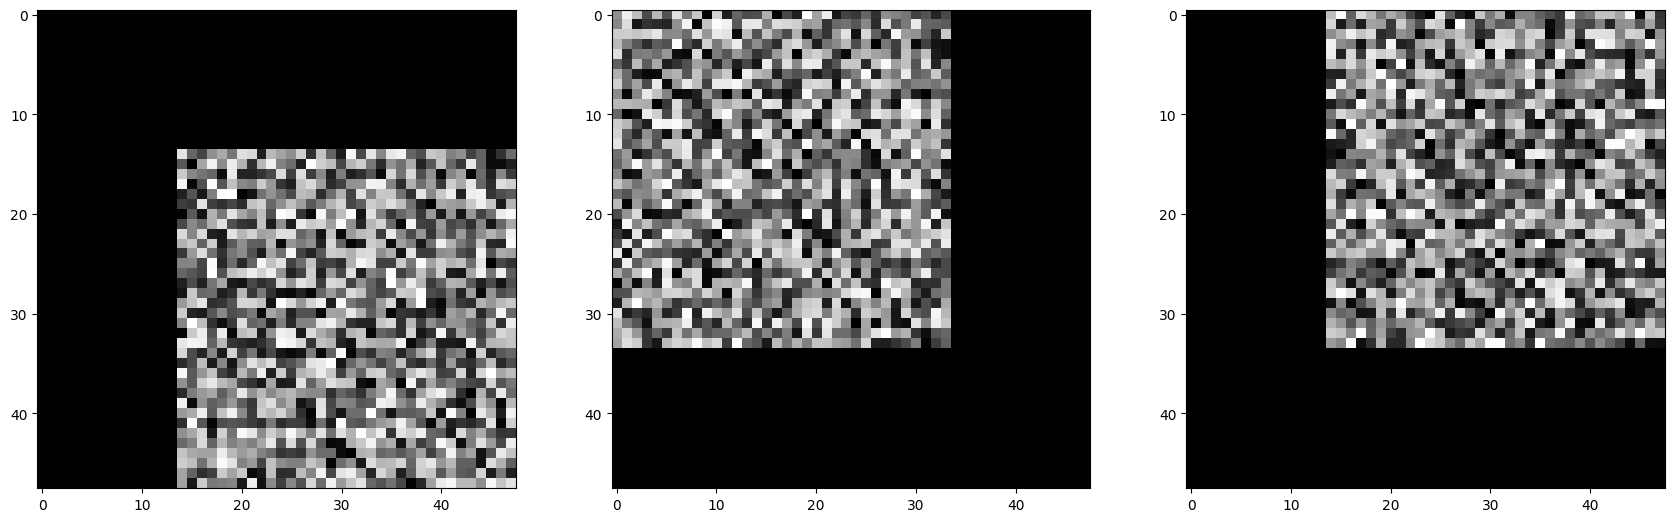

In [ ]:
def create_patch(img, patch_center, patch_size=48):
    """
    Creates a patch from the input image centered at the given coordinates.
    If the patch extends beyond the image boundaries, the out-of-bound areas
    are filled with the air threshold value.

    Parameters:
    img (ndarray): Input image.
    patch_center (tuple): Coordinates (x, y) of the patch center.
    patch_size (int): Size of the patch (default is 48).

    Returns:
    patch (ndarray): The extracted patch from the image, with out-of-bound areas filled.
    coords (tuple): Coordinates of the top-left and bottom-right corners of the patch.
    """
    im = img.copy()  # Make a copy of the input image to avoid modifying the original
    x, y = patch_center
    from_center = patch_size / 2

    # Calculate top-left and bottom-right coordinates of the patch
    tl_y, tl_x = int(y - from_center), int(x - from_center)
    br_y, br_x = int(y + from_center), int(x + from_center)

    # Pad the image if necessary
    pad_y = max(0, -tl_y, br_y - im.shape[0])
    pad_x = max(0, -tl_x, br_x - im.shape[1])

    if pad_y > 0 or pad_x > 0:
        im = np.pad(im, ((pad_y, pad_y), (pad_x, pad_x)), mode='constant', constant_values=AIR_TH)
        tl_y += pad_y
        tl_x += pad_x
        br_y += pad_y
        br_x += pad_x

    # Extract the patch from the image
    patch = im[tl_y:br_y, tl_x:br_x]

    return patch, ((tl_x, tl_y), (br_x, br_y))
# Example usage
img = np.random.randint(0, 256, (100, 100), dtype=np.uint8)  # Example image
patch_center = (10, 10)  # Example patch center
patch, coords = create_patch(img, patch_center)
patch1, coords = create_patch(img, (90,90))
patch2, coords = create_patch(img, (10,90))

print("Patch shape:", patch.shape)  # Should print (48, 48)
print("Patch coordinates:", coords)

show_3_images([patch, patch1, patch2])

In [ ]:
subset_candidate_features = pd.DataFrame()
nodules = {}

for i, uid in enumerate(UIDS):
  print(f"\n[START] - {uid} - case {i+1} out of {len(UIDS)}")

  candidates_for_uid_df = annotations_by_uid(uid, CANDIDATES_DF)
  #print(candidates_for_uid_df)

  print(f"[READIN IMG] - {uid}")

  img_path = os.path.join(LUNA_PATH, "subsets", SUBSET, f"{uid}.mhd") # .mhd path
  mhd_img = sitk.ReadImage(img_path) # SimpleITK object
  img_3d = sitk.GetArrayFromImage(mhd_img)
  img_3d[img_3d < AIR_TH] = AIR_TH # Normalize minimum intensity value

  print(f"[MASK LUNG] - {uid}")
  mask_3d = binarize_lung_3d(img_3d).astype(bool)

  # EXTRACT FEATURES
  candidate_features_df = pd.DataFrame()

  print(f"[FEATURES EXTRACTION START] - {uid} - extracting features for {len(candidates_for_uid_df)} candidates")
  for i, row in candidates_for_uid_df.iterrows():
    debug = True

    slice_ = img_3d[row["z"],:,:] # get slice for candidate
    candidate_roi, _ = create_patch(slice_, (row["y"],row["x"]))

    slice_mask = mask_3d[row["z"],:,:] # get lung mask for slice
    candidate_roi_mask, _ = create_patch(slice_mask, (row["y"],row["x"]))

    if row["Class"]:
      nodules[i] = {"uid": uid, "patch": candidate_roi, "patch_mask": candidate_roi_mask, }

      if debug:
        debugger(candidate_roi, "candidate_roi")
        debugger(candidate_roi_mask, "candidate_roi_mask")
        candidate_roi_masked = candidate_roi.copy()
        candidate_roi_masked[candidate_roi_mask == False] = AIR_TH
        debugger(candidate_roi_masked, "candidate_roi_masked")

    fts = extract_features(candidate_roi, candidate_roi_mask, z_values=(img_3d.shape[0], row["z"]), debug=debug)
    features_df = pd.DataFrame([fts], index=[i])
    features_df["Class"] = row["Class"]

    # print(features_df)
    # print(row["Class"])

    candidate_features_df = pd.concat([candidate_features_df, features_df])


  print(f"[FEATURES EXTRACTION END] - {uid} - extracted features for {len(candidate_features_df)} candidates\n")

  subset_candidate_features = pd.concat([subset_candidate_features, candidate_features_df])


In [ ]:
SAVE_FOLDER_PATH = os.path.join("/content/drive/Shareddrives/IA DL_project/ML IA/LUNA16/feature_extractions/pretrained_gabors", SUBSET, f"custom_features.csv")

len(np.array((subset_candidate_features["contrast"])).nonzero()[0])

62676

In [ ]:
subset_candidate_features

,z_distance_from_boundary,z_distance_from_boundary_percent,area,perimeter,compactness,eccentricity,major_axis_length,minor_axis_length,solidity,extent,...,gabor_features_max54,gabor_features_max55,gabor_features_max56,gabor_features_max61,gabor_features_max62,gabor_features_max63,gabor_features_max64,gabor_features_max65,gabor_features_max66,Class
28397,78,0.154150,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3447.351318,3426.659180,3212.463623,3842.602051,3698.005127,3780.074707,3347.269531,2155.624756,-2566.422607,0.0
28398,80,0.158103,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2775.631348,2841.740723,2461.030273,2439.441650,3072.174561,2275.896484,-340.664612,-3569.417969,-6788.145020,0.0
28399,82,0.162055,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1499.630127,844.014709,1056.540527,295.607544,27.554413,-701.375977,25.468054,1143.208374,941.231506,0.0
28400,82,0.162055,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,824.732605,1204.970093,634.623108,957.673523,664.956604,877.689819,778.307739,1182.547241,951.005554,0.0
28401,83,0.164032,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,506.953003,854.042786,978.531006,459.155273,-201.115997,-608.317017,747.855530,1648.574707,1261.857666,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17632,35,0.065421,5,5.656854,6.400000,0.000000,2.529822,2.529822,1.000000,0.555556,...,-7827.868164,-7296.072754,-6229.063477,994.623291,3112.537598,1095.514404,-5445.366211,-5893.158203,2474.627930,0.0
17633,34,0.063551,21,14.485281,9.991589,0.417965,5.453041,4.953886,0.954545,0.700000,...,-7166.991211,764.591797,1580.574463,2581.968750,300.934540,-3683.617676,-4211.984375,-6027.047363,3457.045654,0.0
17634,34,0.063551,8,7.656854,7.328427,0.577350,3.464102,2.828427,1.000000,0.666667,...,-71.223083,947.531006,3683.741211,2732.856689,-555.561157,-3842.652588,-6816.641602,439.885803,3007.578613,0.0
17635,34,0.063551,72,35.455844,17.459957,0.878284,14.126195,6.754286,0.888889,0.600000,...,-1969.078857,3085.619629,8942.336914,1022.298523,1704.014160,1332.918213,1168.628662,2916.902832,7884.046875,0.0


In [ ]:
subset_candidate_features.to_csv(SAVE_FOLDER_PATH)